In [1]:
import os
import sys
sys.path.append("../")
# put us into the base directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("../")

import hydra
from omegaconf import DictConfig
import pandas as pd
import torch
from src.utils.preprocess import (
    load_tif_seq_data,
    match_with_genomic_data,
    save_processed_data,
    preprocess_data
)
from src.training.data_module import YeastDataModule
# from src.utils.dataset import one_hot_encode_sequence as one_hot, split_by_chrom

from src.utils.utils import set_seed
from src.models.bpnet import BPNet
from torchinfo import summary
import modiscolite


from captum.attr import DeepLift

%load_ext autoreload
%autoreload 2
set_seed(42)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Matplotlib is building the font cache; this may take a moment.
Seed set to 42


Load the config, used for loading the data

In [2]:
# Function to load Hydra configuration
base_dir = os.getcwd()
os.environ["CURRENT_DIR"] = base_dir
def load_config(config_path: str, config_name: str) -> DictConfig:
    with hydra.initialize(config_path=config_path, version_base = "1.3"):
        config = hydra.compose(config_name=config_name)
    return config


# Load the configuration
config = load_config(config_path='../configs', config_name="config")

# Load the data & model

Load the data

In [3]:
# Preprocessing Data
data_dir = config.data.data_dir
tif_seq_file_path = os.path.join(data_dir, config.data.tif_seq_file)
dataset_file_path = os.path.join(data_dir, config.data.dataset_file)
counts_file = os.path.join(data_dir, config.data.counts_file)
preprocessed_file = os.path.join(data_dir, config.data.preprocessed_file)

# chage cwd to the root directory
os.chdir(base_dir)
print(f"Current working directory: {os.getcwd()}" )
print(f"counts_file: {counts_file}")

tif_df = load_tif_seq_data(tif_seq_file_path)
if not os.path.exists(counts_file) or not os.path.exists(preprocessed_file):
    dataset, counts = match_with_genomic_data(tif_df, dataset_file_path)
    save_processed_data(counts, dataset, counts_file, preprocessed_file)

print("Preprocessing completed successfully!")

# Load preprocessed data
counts = torch.load(counts_file)
dataset = pd.read_parquet(preprocessed_file)

print(f"Loaded counts shape: {counts.shape}")
print(f"Loaded dataset shape: {dataset.shape}")

# Splitting Data and Creating Data Loaders
train_idx, val_idx, test_idx, one_hots, counts, dataset = preprocess_data(
    dataset,
    counts,
    True,
    config.data.seq_col,
    set(config.data.val_chroms),
    set(config.data.test_chroms),
)

data_module = YeastDataModule(
    batch_size=config.training.batch_size,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    data=one_hots,
    counts=counts,
)

data_module.setup()

Current working directory: /Users/peter/Developer/Regulate-Me
counts_file: data/saccharomyces_cerevisiae/counts.pt
Preprocessing completed successfully!
Loaded counts shape: torch.Size([6580, 2, 1003])
Loaded dataset shape: (6580, 10)


Load the model

In [4]:
model = BPNet.load_from_checkpoint('./data/best_models/bpnet.ckpt')
model.eval()
print(summary(model, (4, 300)))

Layer (type:depth-idx)                   Output Shape              Param #
BPNet                                    [2, 300]                  --
├─Conv1d: 1-1                            [128, 300]                5,760
├─ReLU: 1-2                              [128, 300]                --
├─ModuleList: 1-13                       --                        (recursive)
│    └─Conv1d: 2-1                       [128, 300]                49,280
├─ModuleList: 1-14                       --                        --
│    └─ReLU: 2-2                         [128, 300]                --
├─ModuleList: 1-13                       --                        (recursive)
│    └─Conv1d: 2-3                       [128, 300]                49,280
├─ModuleList: 1-14                       --                        --
│    └─ReLU: 2-4                         [128, 300]                --
├─ModuleList: 1-13                       --                        (recursive)
│    └─Conv1d: 2-5                       [128, 

# Compute Attribution Scores

Create a wrapper for the model that only outputs the profile (DeepLIFT doesn't work with models that output tuples for the forward pass)

In [5]:
import pytorch_lightning as pl

class ModelWrapper(pl.LightningModule):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        outputs = self.model(x)
        # Assume outputs is a tuple of tensors
        return outputs[0]

In [6]:
wrapped_model = ModelWrapper(model)

dl = DeepLift(wrapped_model)

all_inputs = []
all_grads = []

# Combine the batches of inputs
inputs = []
for input, _ in data_module.val_dataloader():
  inputs.append(input)

input_batch = torch.cat(inputs, dim=0)
input_batch = input_batch[:498,:,:,]

output = wrapped_model(input_batch)

# Convert input to double since autograd doesn't work for int
input_batch_double = input_batch.type(torch.DoubleTensor)
input_batch_double.requires_grad = True

attribution = dl.attribute(input_batch_double, target=(0,0))

input_batch_np = input_batch.detach().numpy()
attribution_np = attribution.detach().numpy()

print(input_batch_np.shape)
print(attribution_np.shape)

/Users/peter/anaconda3/envs/regulate-me/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


(498, 4, 300)
(498, 4, 300)


# Use TF-MoDISco to find motifs

In [7]:

pos_patterns, neg_patterns = modiscolite.tfmodisco.TFMoDISco(
    hypothetical_contribs=attribution_np.transpose((0, 2, 1)),
    one_hot=input_batch_np.transpose((0, 2, 1)),
    max_seqlets_per_metacluster=1000000,
    sliding_window_size=5,#5 is working
    flank_size=3,
    target_seqlet_fdr=0.25,
    n_leiden_runs=3,
    verbose=True,
    trim_to_window_size=20,
    initial_flank_to_add=5,
    final_min_cluster_size = 3
)

modiscolite.io.save_hdf5("./data/modisco_results_bpnet.h5", pos_patterns, neg_patterns, window_size=20)

Using 1563 positive seqlets
Extracted 3589 negative seqlets


# Results

In [8]:
!modisco report -i ./data/modisco_results_bpnet.h5 -o ./data/report_bpnet/

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Matplotlib is building the font cache; this may take a moment.


In [9]:
from IPython.display import HTML

HTML('./data/report_bpnet/motifs.html')

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev
pos_patterns.pattern_0,100,,
pos_patterns.pattern_1,63,,
pos_patterns.pattern_2,38,,
pos_patterns.pattern_3,37,,
pos_patterns.pattern_4,28,,
pos_patterns.pattern_5,28,,
pos_patterns.pattern_6,24,,
pos_patterns.pattern_7,23,,
pos_patterns.pattern_8,19,,
pos_patterns.pattern_9,4,,


Show the sequence logos of all the positive patterns

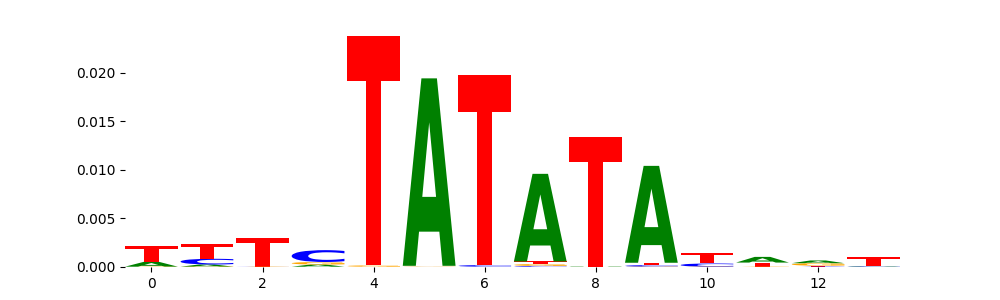

In [13]:
from IPython.display import Image

Image('./data/report_bpnet/trimmed_logos/pos_patterns.pattern_0.cwm.fwd.png')

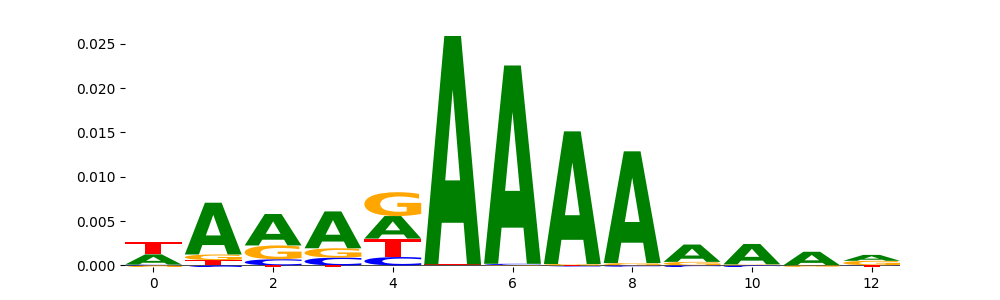

In [11]:
Image('./data/report_bpnet/trimmed_logos/pos_patterns.pattern_1.cwm.fwd.png')

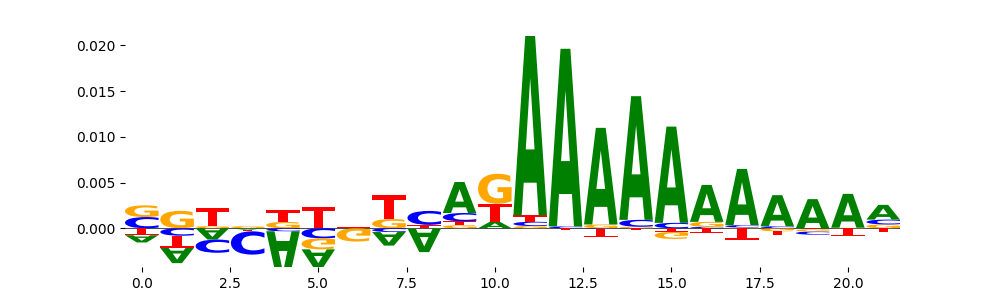

In [14]:
Image('./data/report_bpnet/trimmed_logos/pos_patterns.pattern_2.cwm.fwd.png')